In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
import pymc3 as pm

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
a=np.arange(3)
P=np.array([[0.8,0.1,0.1],[0.05,0.9,0.05],[0.15,0.15,0.7]])
P[:,:-1]


array([[0.8 , 0.1 ],
       [0.05, 0.9 ],
       [0.15, 0.15]])

# Compute the unconditional probability for the states of a  Markov chain.


In [3]:
def unconditionalProbability(Ptrans):
    m = Ptrans.shape[0]

    P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

    I = np.eye(m)
    U = np.ones((m, m))
    u = np.ones(m)

    return np.linalg.solve((I - P + U).T, u)

# Equilibrium probabilities

In [4]:


PU = unconditionalProbability(P[:,:-1])
print(PU)
print(np.sum(PU))


[0.27272727 0.54545455 0.18181818]
1.0


In [5]:
Pt=P[:,:-1]
print(1. - Pt.sum(axis=1))
print(np.concatenate((Pt.T,[1. - Pt.sum(axis=1)])).T)

[0.1  0.05 0.7 ]
[[0.8  0.1  0.1 ]
 [0.05 0.9  0.05]
 [0.15 0.15 0.7 ]]


# Create a sample


In [6]:
firstpoint = np.random.choice(3, 1, p=PU)
print(firstpoint)
sample = [firstpoint[0]]
sample
for i in range(1,1000):
    sample = np.concatenate((sample,np.random.choice(3,1,p=P[sample[-1]])))

[1]


(array([1.515, 0.   , 0.   , 0.   , 0.   , 2.76 , 0.   , 0.   , 0.   ,
        0.725]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

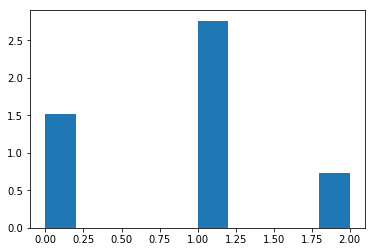

In [7]:
plt.hist(sample, normed=True)


(-0.2, 2.2)

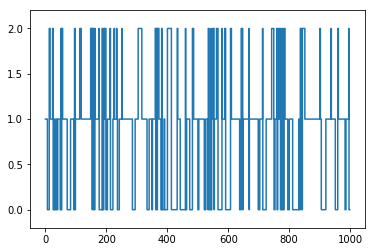

In [8]:
plt.plot(sample[:1000], drawstyle='steps-mid')
plt.ylim((-0.2,2.2))

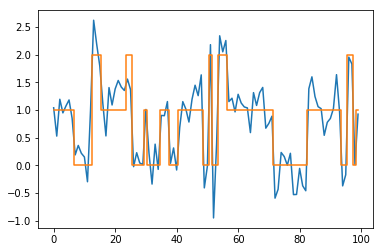

In [9]:
measurement = sample + 0.3*np.random.randn(1000)
plt.plot(measurement[:100])
plt.plot(sample[:100], drawstyle='steps-mid')

# Now we want to create a P matrix that reflects the states


In [10]:
PT = np.tile(P.T,(10,1,1))
PS = np.choose(sample[:10],PT.T).T
sample[:10]


array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

# MAIN CODE

In [11]:

import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla
# Two state model for simplicity.
N_states = 3
N_chain = len(sample)

# Transition probability stochastic
theta = np.ones((N_states,N_states)) + 1.

In [12]:

class HMMStatesN(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states-1)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states-1)
    
    """

    def __init__(self, PA=None, P=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        P = self.P
        PA = self.PA
        
        # calculate equilibrium
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        #P = tt.switch(x[:-1],P1,P2)
        
        PS = P[x[:-1]]
        
        x_i = x[1:]
        ou_like = pm.Categorical.dist(PS).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [13]:
from scipy import optimize
with pm.Model() as model:
    # N_states state model
    #P = tt.stack( [pm.Dirichlet('P_'+str(i), a=np.ones(N_states)) for i in range(N_states)] )
    
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    
#    Pfull = tt.dmatrix('Pfull')
#    PA = tt.dmatrix('PA')
    A = tt.dmatrix('A')
        
    A = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(A.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',PA=PA, P=P, observed=sample)
    
    # start = pm.find_MAP(fmin=optimize.fmin_powell)
    # step = pm.Metropolis()
 
    %time approx = pm.fit(n=20000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 513.69: 100%|██████████| 20000/20000 [00:24<00:00, 829.85it/s]
Finished [100%]: Average Loss = 513.69


CPU times: user 27.4 s, sys: 1.49 s, total: 28.9 s
Wall time: 28.6 s


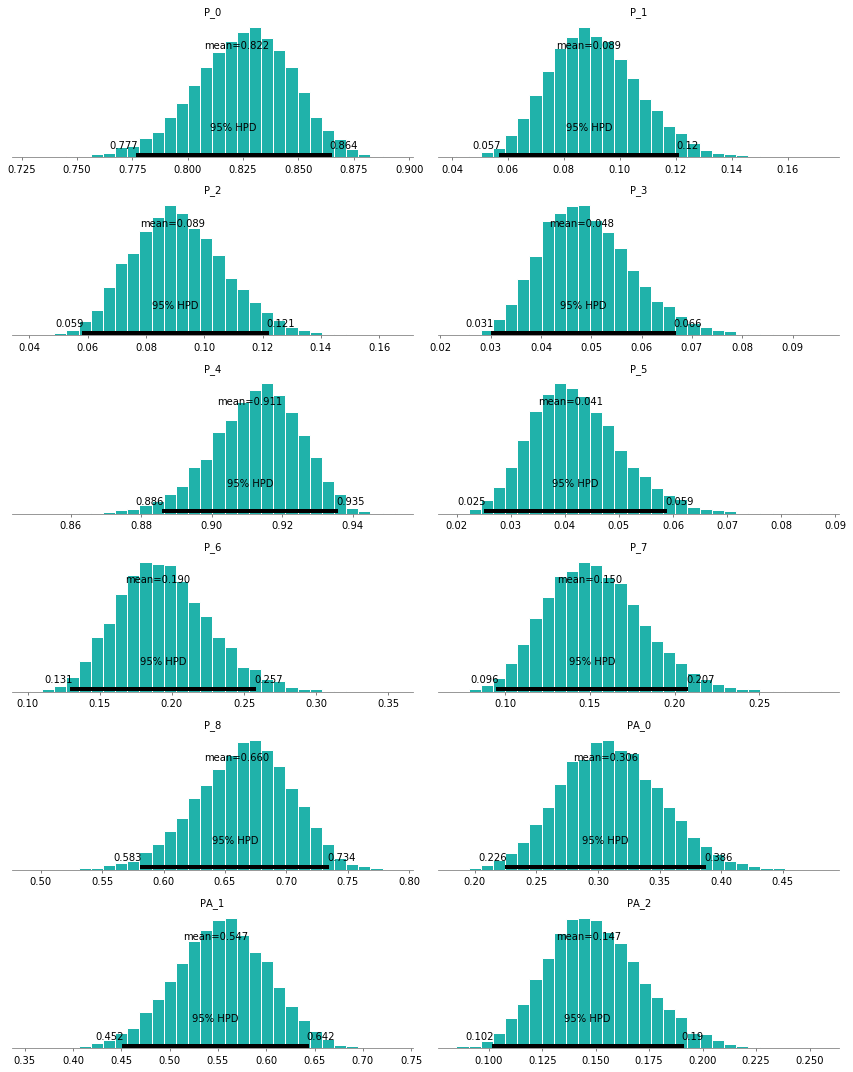

In [14]:
pm.plot_posterior(approx.sample(10000), color='LightSeaGreen');


In [15]:
means

{'P_stickbreaking__': array([[ 2.23072675e+00, -1.55801501e-04],
        [-2.30916647e+00,  3.11611776e+00],
        [-7.70558384e-01, -1.50316168e+00]])}

In [16]:
cov

array([[0.02280954, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.07538358, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04028191, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.04639581, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04571908,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05534681]])